# Create xarray Data Cubes

## Table of Content
- [Data Input](#input)
- [Output](#output)
- [This has to be changed](#changes)
- [Load Packages](#packages)
- [Import Data](#import_data)
- [Plot Temperature & Precipitation Data and check Coordinates](#plot_check)
- [Show Data Structure](#showData)
- [Merge Temperatrue & Precipitation Arrays](#merge_TempPre)
- [Create DVV DataFrame](#DVV_DF)
- [Some additional Plots](#more_plots)
- [Cut Timeseries for one station & a certain Time](#cut)
- [Fill Data-Gaps in dvv with NaN](#nan)

<a id='input'></a>
### Input Data:
- temperature<br>
- precipitation<br>
- seismic velocity variations (dv/v)<br>

<a id='output'></a>
### Output:
- 3 data cubes for each parameter<br>
    - cubes have same x and y dimension (lat and long)<br>
    - cubes habe different z dimension (time)<br>
    - to see axis labels check:<br>
        - xr_tmean.lon (x-axis)<br>
        - xr_tmean-lat (y-axis)<br>
        - df_merged.index (z-axis)<br>
            

<a id='changes'></a>
### This has to be changed:

- at the moment, I use only one year of data (faster)
- discuss big xarray (mostely NaN)
- discuss coordinate systhem
- create xarray for DVV (but discuss first)

## For Now
I only use one station. To select the data for one station, import the data (runfirst two cells), jup to [Cut Timeseries for one station & a certain Time](#cut) and run this part of code.

<a id='packages'></a>
## Load Packages

In [25]:
# load packages
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob

import warnings
warnings.filterwarnings('ignore')

<a id='import_data'></a>
## Import Data

In [2]:
# import tmean and ppt and restructure these to xarray

nc_ppt = netCDF4.Dataset('../DATA/ppt.nc', mode='r')
xr_ppt = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_ppt))

nc_tmean = netCDF4.Dataset('../DATA/tmean.nc', mode='r')
xr_tmean = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_tmean))

# import NCstations as DF(station informations with coordinates)

df_ncstations = pd.read_csv('../DATA/stations.csv')

In [3]:
# look at the data structure
xr_ppt['ppt']

<xarray.DataArray 'ppt' (t: 13224, lon: 288, lat: 287)>
[1093042944 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.9 ... -113.1 -113.1 -113.0
  * t        (t) datetime64[ns] 1985-01-01 1985-01-02 ... 2021-03-15 2021-03-16
  * lat      (lat) float64 31.03 31.07 31.12 31.16 ... 42.84 42.88 42.93 42.97
Attributes:
    units:     mm
    data_max:  429.7349853515625
    data_min:  -9999.0

<a id='plot_check'></a>
### Plot Temperature & Precipitation Data and check Coordinates

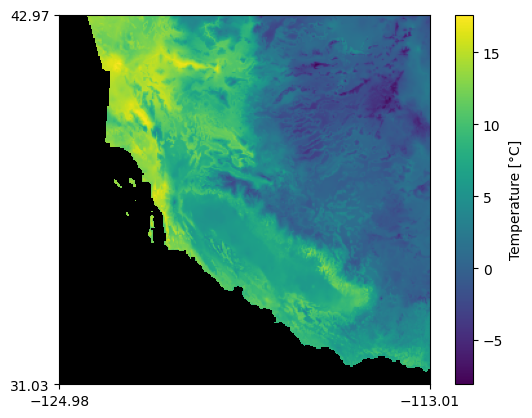

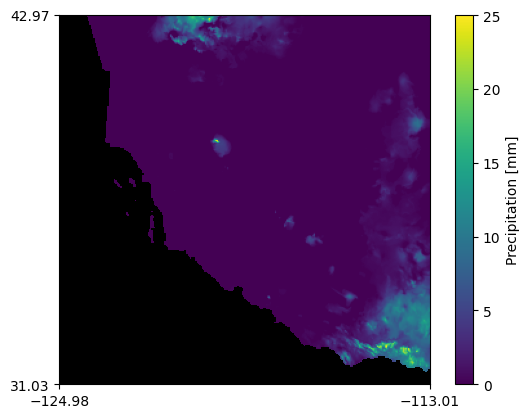

In [3]:
# define x and y as coordinates
mminx=float(xr_tmean.lon[0])
mmaxx=float(xr_tmean.lon[-1])
mminy=float(xr_tmean.lat[0])
mmaxy=float(xr_tmean.lat[-1])

# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black') # for no data (-9999) use black

# mask xarrays for grid cells without data (-9999)
masked_tmean = np.ma.masked_where(xr_tmean.tmean[1] == xr_tmean.tmean[1].min(), xr_tmean.tmean[1])
masked_ppt = np.ma.masked_where(xr_ppt.ppt[150] == xr_ppt.ppt[150].min(), xr_ppt.ppt[150])

# plot the temperature
plt.imshow(masked_tmean,extent=[mminx,mmaxx,mminy,mmaxy], origin='lower', cmap=cmap)
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Temperature [°C]')
plt.show()

# plot the precipitation
plt.imshow(masked_ppt,extent=[mminx,mmaxx,mminy,mmaxy], origin='lower', cmap=cmap)
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Precipitation [mm]')
plt.show()

<a id='showData'></a>
### Show Data Structure


In [10]:
path ='../DATA/DVV-90-DAY-2.0-4.0/*'
flist = sorted(glob.glob(path))

# Example of the first file
sta = flist[0].split('/')[-1].split('.')[1] # first file station
net = flist[0].split('/')[-1].split('.')[0] # first file network
print('first network: {} \nfirst station: {}'.format(net, sta))

pd_sta = pd.read_csv(flist[0]) # PandaDataFrame including DVV and CC data (first station)
pd_sta.head()

first network: 8E 
first station: MB01


,DATE,DVV,CC
0,2011-09-28,-0.396076,0.549346
1,2011-09-29,-0.370092,0.648979
2,2011-09-30,-0.355830,0.718367
3,2011-10-01,-0.321779,0.800198
4,2011-10-02,-0.268387,0.844070


<a id='merge_TempPre'></a>
## Merge Temperatrue & Precipitation Arrays

In [9]:
# Megre tmean Xarray with ppt Xarray !!! ATTENTION use a lot of time !!!

# xr_merge=xr.merge([xr_tmean,xr_ppt])

<a id='DVV_DF'></a>
## Create DVV DataFrame

In [11]:
# create a DF with all Stations

flist_short = flist
df_merged = pd.DataFrame() # predefine a timevector as index and cut the tmean and ppt to these timeperiod.
for one_flist in flist_short:
    sta = one_flist.split('/')[-1].split('.')[1]
    net=one_flist.split('/')[-1].split('.')[0]
    pd_sta = pd.read_csv(one_flist)
    pd_sta.pop('CC')
    pd_sta = pd_sta.set_index('DATE')
    pd_sta. index = pd. to_datetime (pd_sta. index) # define index in datetime format
    pd_sta_year=pd_sta[pd_sta.index.year==2011] # select one year
    colname = str(net)+'.'+str(sta)+'_DVV'
    pd_sta_year.rename(columns = {'DVV':colname}, inplace = True)
    df_merged = pd.concat([df_merged,pd_sta_year], axis=1)
    try:
        station_data = df_ncstations[(df_ncstations.Network==str(net)) & (df_ncstations.Station==str(sta))]
        sta_lat = float(station_data.Latitude)
        sta_lon = float(station_data.Longitude)
        print(sta_lon,sta_lat) # get Latitude and Longitude fro NCstation file
    except:
        print(str(net),str(sta),' no location')
        
    
# note: not all station codes of the DVV data are in the NCStation.csv overview document.

-119.030418 37.62801
-119.037674 37.629192
-119.033936 37.638859
-119.016983 37.630184
-119.027267 37.618389
-119.047668 37.616463
-119.046783 37.633858
-119.028557 37.645721
-119.004463 37.632767
-119.058182 37.643257
-119.020981 37.611378
AZ BZN  no location
AZ CPE  no location
AZ CRY  no location
AZ FRD  no location
-116.959602 33.026199
-116.767601 33.729401
-116.422501 32.8927
AZ MONP2  no location
-116.739403 33.651501
-118.4879 32.915
-116.459702 33.611801
-116.459702 33.611801
AZ SIO5  no location
AZ SMER  no location
AZ SND  no location
-116.459702 33.611801
-116.680901 33.619202
AZ TRO  no location
AZ WMC  no location
-116.353897 33.166599
BC CBX  no location
BC CCX  no location
BC RMX  no location
BC TJX  no location
BC TKX  no location
-121.86554 37.95397
-122.23558 37.87622
-122.24318 37.87492
BK BRIB  no location
-122.26099 37.87352
-120.38651 38.03455
-122.4584 38.34526
-121.8021 40.2946
-123.337498 39.46897
-120.72791 40.61835
-123.0011 37.69782
-122.71595 39.65471
-121

In [12]:
# create DVV arry & compare the station coordinates with the temperature and precipitation grid cell coordinates

blank_array = np.zeros((288,287,df_merged.shape[0]))*np.nan
arr_lat = np.array(xr_tmean.lat)
arr_lon = np.array(xr_tmean.lon)

lon_list = []
lon_idx = []
lat_list = []
lat_idx = []

for one_flist in flist_short:
    sta = one_flist.split('/')[-1].split('.')[1]
    net=one_flist.split('/')[-1].split('.')[0]
    try:
        station_data=df_ncstations[(df_ncstations.Network==net) & (df_ncstations.Station==sta)]
        sta_lat=float(station_data.Latitude)
        sta_lon=float(station_data.Longitude)
        print(sta_lon,sta_lat) # get Latitude and Longitude from NCstation file
        
        # find position in 3D-array
        difference_array_lon = np.absolute(arr_lon-sta_lon)
        difference_array_lat = np.absolute(arr_lat-sta_lat)

        # find the index of minimum element from the array
        index_lon = difference_array_lon.argmin()
        index_lat = difference_array_lat.argmin()
        
        print("Nearest element to the given values in longitude is : ", arr_lon[index_lon])
        print("Index of nearest value in longitude is : ", index_lon)
        lon_list.append(arr_lon[index_lon])
        lon_idx.append(index_lon)
        
        print("Nearest element to the given values in latitude is : ", arr_lat[index_lat])
        print("Index of nearest value in latitude is : ", index_lat)
        lat_list.append(arr_lat[index_lat])
        lat_idx.append(index_lat)
        
        colname = str(net)+'.'+str(sta)+'_DVV'
        
        ll = np.array(df_merged[colname]) #from DF column to vector (one-dimensional array)
        blank_array[index_lon,index_lat,:] = ll
        
    except:
        print(str(net),str(sta),' no location')
        
        
# There is a lot of printing output in this for loop, these is just to contorl the process a bit, but you can comment it.     

-119.030418 37.62801
Nearest element to the given values in longitude is :  -119.0165598025641
Index of nearest value in longitude is :  143
Nearest element to the given values in latitude is :  37.62600806451613
Index of nearest value in latitude is :  158
-119.037674 37.629192
Nearest element to the given values in longitude is :  -119.0582561462963
Index of nearest value in longitude is :  142
Nearest element to the given values in latitude is :  37.62600806451613
Index of nearest value in latitude is :  158
-119.033936 37.638859
Nearest element to the given values in longitude is :  -119.0165598025641
Index of nearest value in longitude is :  143
Nearest element to the given values in latitude is :  37.62600806451613
Index of nearest value in latitude is :  158
-119.016983 37.630184
Nearest element to the given values in longitude is :  -119.0165598025641
Index of nearest value in longitude is :  143
Nearest element to the given values in latitude is :  37.62600806451613
Index of n

In [12]:
print(blank_array[143,135,:]) # check with longitude and latitude index from above if data is in the cube

[-2.07627752e-01 -2.14396659e-01 -2.17085657e-01 -2.19009972e-01
 -2.20734268e-01 -1.99297656e-01 -2.02424035e-01 -2.03850753e-01
 -2.03386026e-01 -2.03835970e-01 -2.03796848e-01 -2.05596679e-01
 -2.09967913e-01 -2.10027760e-01 -2.16662545e-01 -2.18384154e-01
 -2.20172761e-01 -2.22064463e-01 -2.22495996e-01 -2.22781509e-01
 -2.23204820e-01 -2.27211113e-01 -2.32781729e-01 -2.39905769e-01
 -2.43251145e-01 -2.44819866e-01 -2.48730361e-01 -2.50215783e-01
 -2.51168181e-01 -2.52508352e-01 -2.53091110e-01 -2.51447042e-01
 -2.49835634e-01 -2.49726997e-01 -2.53920439e-01 -2.56370454e-01
 -2.59460475e-01 -2.61633546e-01 -2.62601347e-01 -2.63700833e-01
 -2.63188827e-01 -2.65288161e-01 -2.64931349e-01 -2.64941231e-01
 -2.63959908e-01 -2.65147493e-01 -2.62667188e-01             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

In [56]:
blank_array

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

<a id='more_plots'></a>
### Some additional Plots

In [13]:
# create DataFrame including seismic stations as index for map grid
df = pd.DataFrame()
df['lon'] = lon_list
df['lon_idx'] = lon_idx
df['lat'] = lat_list
df['lat_idx'] = lat_idx
df

,lon,lon_idx,lat,lat_idx
0,-119.016560,143,37.626008,158
1,-119.058256,142,37.626008,158
2,-119.016560,143,37.626008,158
3,-119.016560,143,37.626008,158
4,-119.016560,143,37.626008,158
...,...,...,...,...
612,-121.143073,92,37.626008,158
613,-121.476644,84,37.792944,162
614,-121.643429,80,38.001613,167
615,-121.643429,80,38.001613,167


In [25]:
print(np.where(df['lon_idx']==150),np.where(df['lat_idx']==150))

(array([229, 529]),) (array([384]),)


In [29]:
df.iloc[384]

lon       -117.265313
lon_idx    185.000000
lat         37.292137
lat_idx    150.000000
Name: 384, dtype: float64

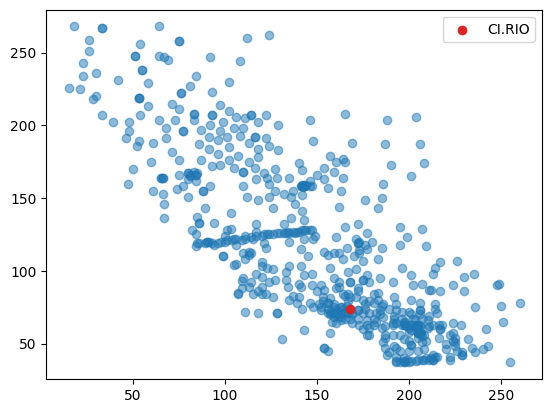

In [21]:
plt.scatter(df['lon_idx'], df['lat_idx'], alpha=0.5)
plt.scatter(168, 74, alpha=1, color='C3', label='CI.RIO')
plt.legend()

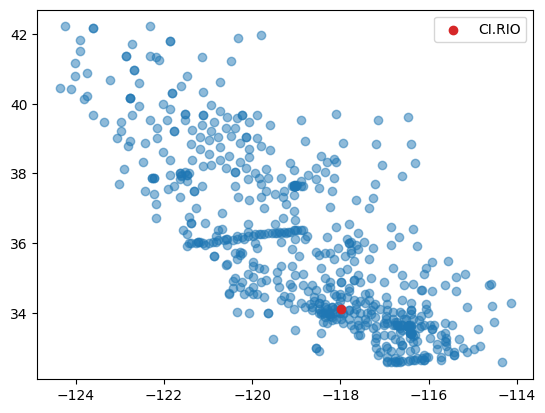

In [20]:
plt.scatter(df['lon'], df['lat'], alpha=0.5)
plt.scatter(-117.97956, 34.10473, alpha=1, color='C3', label='CI.RIO')
plt.legend()

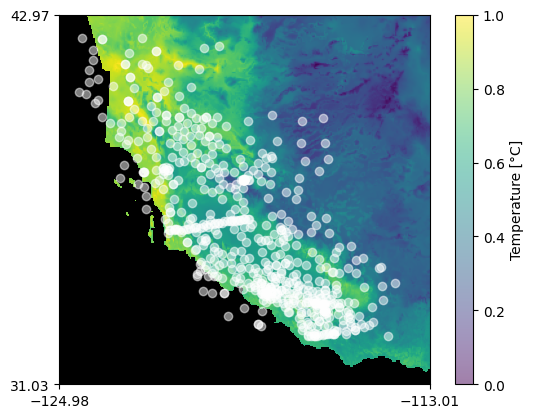

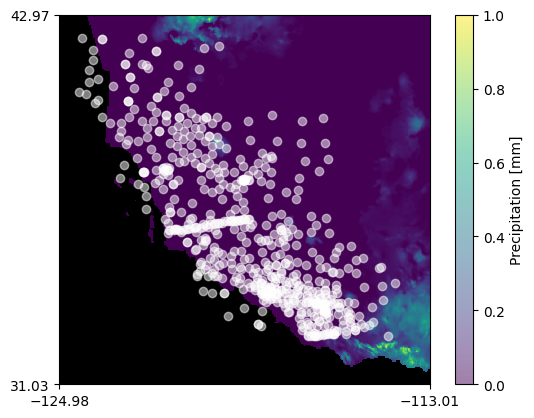

In [17]:
# define x and y as coordinates
mminx=float(xr_tmean.lon[0])
mmaxx=float(xr_tmean.lon[-1])
mminy=float(xr_tmean.lat[0])
mmaxy=float(xr_tmean.lat[-1])

# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black') # for no data (-9999) use black

# mask xarrays for grid cells without data (-9999)
masked_tmean = np.ma.masked_where(xr_tmean.tmean[1] == xr_tmean.tmean[1].min(), xr_tmean.tmean[1])
masked_ppt = np.ma.masked_where(xr_ppt.ppt[150] == xr_ppt.ppt[150].min(), xr_ppt.ppt[150])

# plot the temperature
plt.imshow(masked_tmean,extent=[mminx,mmaxx,mminy,mmaxy], origin='lower', cmap=cmap)
plt.scatter(df['lon'], df['lat'], alpha=0.5, color='white')
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Temperature [°C]')
plt.show()

# plot the precipitation
plt.imshow(masked_ppt,extent=[mminx,mmaxx,mminy,mmaxy],origin='lower', cmap=cmap)
plt.scatter(df['lon'], df['lat'], alpha=0.5, color='white')
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Precipitation [mm]')
plt.show()

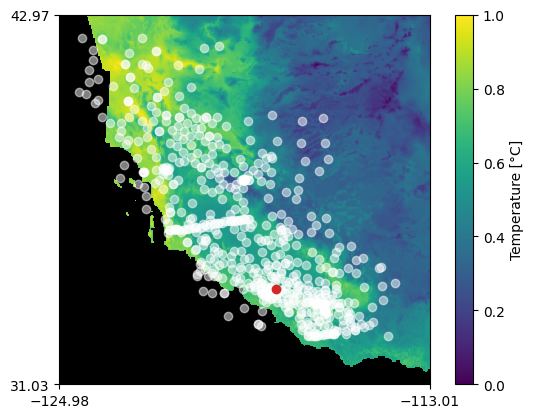

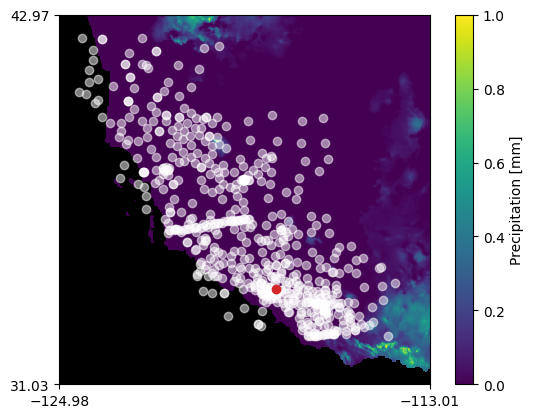

In [22]:
# define x and y as coordinates
mminx=float(xr_tmean.lon[0])
mmaxx=float(xr_tmean.lon[-1])
mminy=float(xr_tmean.lat[0])
mmaxy=float(xr_tmean.lat[-1])

# define color map
cmap = plt.cm.get_cmap('viridis') # for data use colormap viridis
cmap.set_bad(color='black') # for no data (-9999) use black

# mask xarrays for grid cells without data (-9999)
masked_tmean = np.ma.masked_where(xr_tmean.tmean[1] == xr_tmean.tmean[1].min(), xr_tmean.tmean[1])
masked_ppt = np.ma.masked_where(xr_ppt.ppt[150] == xr_ppt.ppt[150].min(), xr_ppt.ppt[150])

# plot the temperature
plt.imshow(masked_tmean,extent=[mminx,mmaxx,mminy,mmaxy], origin='lower', cmap=cmap)
plt.scatter(df['lon'], df['lat'], alpha=0.5, color='white')
plt.scatter(-117.97956, 34.10473, alpha=1, color='C3')
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Temperature [°C]')
plt.show()

# plot the precipitation
plt.imshow(masked_ppt,extent=[mminx,mmaxx,mminy,mmaxy],origin='lower', cmap=cmap)
plt.scatter(df['lon'], df['lat'], alpha=0.5, color='white')
plt.scatter(-117.97956, 34.10473, alpha=1, color='C3')
plt.xticks([mminx,mmaxx])
plt.yticks([mminy,mmaxy])
plt.colorbar(label='Precipitation [mm]')
plt.show()

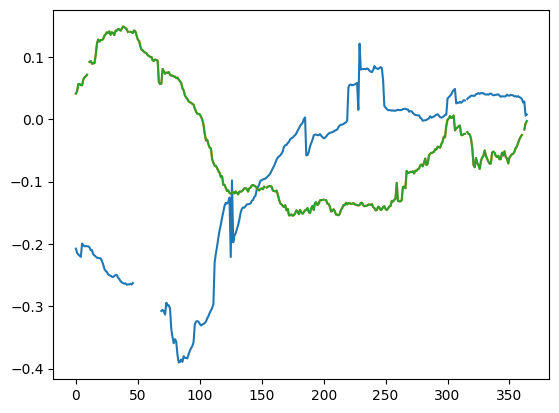

In [74]:
# plot timeserie of two stations
plt.plot(blank_array[143,135,:])
plt.plot(blank_array[46,191,:]) # lon, lat, time

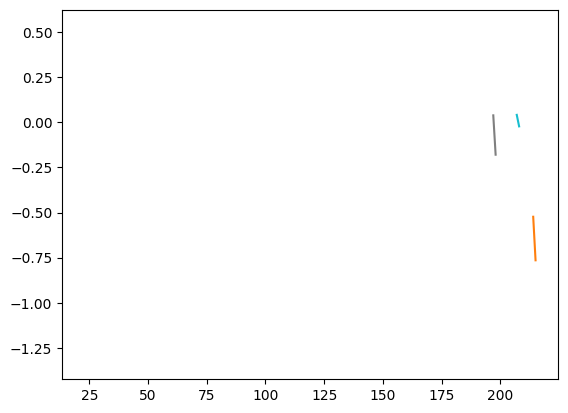

In [62]:
plt.plot(blank_array[:,:,100])

<a id='cut'></a>
# Cut Timeseries for one station & a certain Time

In [5]:
# define the time and station as station index
sta_lon = 168 # station longitude index
sta_lat = 74 # station latitude index

start_t = "2000-01-01" # start time
end_t = "2020-12-31" # end time

In [6]:
# cut the xarray to the date
ppt_test = xr_ppt.sel(t=slice(start_t, end_t))
tmean_test = xr_tmean.sel(t=slice(start_t, end_t))
ppt_test

<xarray.Dataset>
Dimensions:  (t: 7671, lon: 288, lat: 287)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.9 ... -113.1 -113.1 -113.0
  * t        (t) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-30 2020-12-31
  * lat      (lat) float64 31.03 31.07 31.12 31.16 ... 42.84 42.88 42.93 42.97
Data variables:
    ppt      (t, lon, lat) float64 ...

In [7]:
# choose the station and save the array
ppt = ppt_test.ppt[:,sta_lon,sta_lat] # station CI.RIO
np.save('../DATA/ppt_RIO_test',[ppt.to_numpy(),ppt.t.to_numpy()])

temp = tmean_test.tmean[:,sta_lon,sta_lat] # station CI.RIO
np.save('../DATA/temp_RIO_test',[temp.to_numpy(),temp.t.to_numpy()])

In [22]:
import pandas as pd
pd_data = pd.read_csv('../DATA/DVV-90-DAY-2.0-4.0/CI.RIO.csv') # read in one station file
pd_data.head()

,DATE,DVV,CC
0,1999-10-21,-0.765280,0.875691
1,1999-10-25,-0.759454,0.862668
2,1999-10-26,-0.802919,0.867514
3,1999-10-28,-0.934312,0.876715
4,1999-10-29,-1.474492,0.880135


In [23]:
s_t, e_t = np.where(pd_data['DATE']==start_t)[0][0], np.where(pd_data['DATE']==end_t)[0][0]

In [24]:
data_cut = pd_data[s_t:e_t+1]
data_cut.head()

,DATE,DVV,CC
67,2000-01-01,-1.480605,0.893217
68,2000-01-02,-1.478723,0.893602
69,2000-01-03,-1.473266,0.893879
70,2000-01-04,-1.475269,0.894096
71,2000-01-05,-1.478872,0.894225


In [12]:
temp = tmean_test.tmean[:,sta_lon,sta_lat] # station CI.RIO
np.save('../DATA/dvv_RIO_test',[data_cut['DVV'],data_cut['DATE']])

<a id='nan'></a>
## Fill Data-Gaps in dvv with NaN

In [13]:
import numpy as np
ppt = np.load('../DATA/ppt_RIO_test.npy', allow_pickle=True)
temperature = ppt[0]
temp = np.load('../DATA/temp_RIO_test.npy', allow_pickle=True)
relative_humidity = temp[0]
dvv = np.load('../DATA/dvv_RIO_test.npy', allow_pickle=True)
dvv_data = dvv[0]
print(len(temperature), len(relative_humidity), len(dvv_data))

7671 7671 7486


In [14]:
import pandas as pd
timeserie = pd.date_range(start=start_t, end=end_t, freq='D') # create continuos time serie
timeserie

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=7671, freq='D')

In [16]:
# find the missing dates
diff = timeserie.difference(dvv[1]) # this elements are only in the continuos time serie
diff

DatetimeIndex(['2000-01-18', '2000-02-18', '2000-02-19', '2000-02-20',
               '2000-02-21', '2000-05-19', '2000-05-20', '2000-05-21',
               '2000-05-22', '2000-05-23',
               ...
               '2020-03-01', '2020-03-02', '2020-03-03', '2020-08-19',
               '2020-08-20', '2020-08-21', '2020-08-22', '2020-08-23',
               '2020-08-24', '2020-08-25'],
              dtype='datetime64[ns]', length=185, freq=None)

In [17]:
# create a new dataframe containing the missing dates and Nan
df_new = pd.DataFrame(index=diff, columns=['dvv'], data=np.full(len(diff), np.nan))
df_new.head()

,dvv
2000-01-18,NaN
2000-02-18,NaN
2000-02-19,NaN
2000-02-20,NaN
2000-02-21,NaN


In [18]:
# dataframe with containing the dvv
df_dvv = pd.DataFrame(index=dvv[1], columns=['dvv'], data=dvv[0])
df_dvv.head()

,dvv
2000-01-01,-1.480605
2000-01-02,-1.478723
2000-01-03,-1.473266
2000-01-04,-1.475269
2000-01-05,-1.478872


In [20]:
# merge the two dataframes to and up with all dates
df_concat = pd.concat([df_new, df_dvv])
df_concat.index = pd.to_datetime(df_concat.index)
df_concat = df_concat.sort_index(ascending=True)
df_concat.head()

,dvv
2000-01-01,-1.480605
2000-01-02,-1.478723
2000-01-03,-1.473266
2000-01-04,-1.475269
2000-01-05,-1.478872


In [21]:
# save the filled and complete dataframe
np.save('../DATA/dvv_RIO_filled_test',[df_concat['dvv'],df_concat.index.astype(str)])